In [1]:
import pandas as pd 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 매출 데이터셋 로드 

In [3]:
closedDeals = pd.read_csv('./datasets/Funnel/olist_closed_deals_dataset.csv', encoding='cp949')
qualifiedLeads = pd.read_csv('./datasets/Funnel/olist_marketing_qualified_leads_dataset.csv', encoding='cp949')

In [4]:
ordersItemDataSet = pd.read_csv('./datasets/Org/olist_order_items_dataset.csv', encoding='cp949')
ordersDataSet = pd.read_csv('./datasets/Org/olist_orders_dataset.csv', encoding='cp949')
paymentsDataSet = pd.read_csv('./datasets/Org/olist_order_payments_dataset.csv', encoding='cp949')
sellersDataSet = pd.read_csv('./datasets/Org/olist_sellers_dataset.csv', encoding='UTF8')
productsDataSet = pd.read_csv('./datasets/Org/olist_products_dataset.csv', encoding = 'cp949')
cateTranslateDataSet = pd.read_csv('./datasets/Org/product_category_name_translation.csv', encoding = 'cp949')

In [5]:
cateTranslateDataSet.columns = ['product_category_name','product_category_name_english']

In [6]:
ordersDataSet['order_approved_at_yearMonth'] = pd.to_datetime(ordersDataSet['order_approved_at']).dt.strftime('%Y-%m') 

In [7]:
#checkContact = pd.merge(qualifiedLeads, closedDealsWonDate, how = 'left', on ='mql_id')
paymentOrders = pd.merge(ordersDataSet, paymentsDataSet, how = 'left', on ='order_id')
#monthly_sales =
monthly_sales = paymentOrders.groupby('order_approved_at_yearMonth')['payment_value'].sum().reset_index()

In [8]:
ordersItemDataSet.head()
itemsDataSet = pd.merge(ordersItemDataSet, productsDataSet, how = 'left', on ='product_id')[['order_id','product_id','seller_id','product_category_name']]
firstPaymentDataSet = pd.merge(itemsDataSet, paymentOrders, how = 'left', on ='order_id')[['order_id','product_id','seller_id','product_category_name','payment_value','order_purchase_timestamp']]


In [9]:
secondPaymentDataSet = pd.merge(firstPaymentDataSet, cateTranslateDataSet, how = 'left', on ='product_category_name')

In [10]:
cateTranslateDataSet.columns = ['product_category_name','product_category_name_english']


In [11]:
secondPaymentDataSet.head()
secondPaymentDataSet = pd.merge(firstPaymentDataSet, cateTranslateDataSet, how = 'left', on ='product_category_name')
secondPaymentDataSet['order_purchase_timestamp_month'] = pd.to_datetime(ordersDataSet['order_approved_at']).dt.strftime('%Y-%m') 

In [12]:
#minmax 걸고, 그 다음에 sellerid 테이블을 기준으로 걸면 될듯 
secondPaymentDataSet.head()
productCategoryTable = secondPaymentDataSet.groupby(['seller_id','product_category_name']).agg({'order_purchase_timestamp':['min','max']}).reset_index()

In [13]:
categorySales = secondPaymentDataSet.groupby(['product_category_name_english','order_purchase_timestamp']).sum('payment_value').reset_index()
categorySales.columns = ['카테고리명','년-월', '총구매금액']

In [14]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우

## 분기/월 별로 전환율이 어떻게 되는지 

### 계약 체결 여부 확인 

그 전에 계약한 리드와 세부 정보를 확인하기 위해 조인 함 

In [15]:
closedDealsWonDate = closedDeals[['mql_id','won_date','business_segment', 'lead_behaviour_profile', 'declared_monthly_revenue', 'declared_product_catalog_size', 'business_type', 'average_stock','has_gtin','has_company','lead_type']]
checkContact = pd.merge(qualifiedLeads, closedDealsWonDate, how = 'left', on ='mql_id')

데이터 전처리 - 'won_date'가 NULL이면 'N', 'won_date'가 NULL이 아니면 'Y'임 

In [16]:
checkContact.loc[checkContact['won_date'].notna(),'wonYN'] = 'Y'
checkContact.loc[checkContact['won_date'].isna(),'wonYN'] = 'N'

데이터 전처리 - 날짜 column들이 object 자료형이면, 기간 관련 연산이 되지 않아서 날짜 타입으로 타입캐스팅을 진행하였음 

In [17]:
checkContact['won_date'] = checkContact['won_date'].fillna(pd.Timestamp('1970-01-01 01:00'))
checkContact['won_date'] = pd.to_datetime(checkContact['won_date']).dt.date
checkContact['won_date'] = pd.to_datetime(checkContact['won_date'] )
checkContact['year-month'] = checkContact['won_date'].dt.strftime('%Y-%m') 

전환율 계산(전환한 기업 수 계산)

In [18]:
ConvertionRateCountTable = checkContact 

In [19]:
ConvertionRateCount = ConvertionRateCountTable[ConvertionRateCountTable['wonYN']=='Y'].groupby('year-month').size().reset_index(name = 'successCount')

### 처음에 랜딩페이지에 연락처를 남긴 사람들의 데이터를 전처리함 

In [20]:
InitialContect = checkContact

In [21]:
InitialContect['first_contact_date'] = pd.to_datetime(InitialContect['first_contact_date'])

## 년-월로 날짜 데이터를 전처리 한 후, 분기별로 전환율을 구함 

In [22]:
InitialContect['year-month'] =  InitialContect['first_contact_date'].dt.strftime('%Y-%m') 

In [23]:
ContactCount = InitialContect.groupby('year-month').size().reset_index(name = 'contactCount')

In [24]:
finalData = pd.merge(ContactCount[['year-month','contactCount']],ConvertionRateCount[['year-month','successCount']],on='year-month',how='left')

In [25]:
#년-월별 전환율 계산 
finalData['conversionRate'] = (finalData['successCount'] /sum(finalData['contactCount']))*100

In [26]:
finalData['quarter'] = pd.to_datetime(finalData['year-month']).dt.year.astype('str')+'-'+pd.to_datetime(finalData['year-month']).dt.quarter.astype('str')

In [27]:
#분기별 전환율 전에 총 연락 수, 계약 수 
quarterData = finalData.groupby('quarter').sum(['contactCount','successCount']).reset_index()

In [28]:
#분기별 전환율
quarterData['retention'] = quarterData['successCount']/sum(quarterData['contactCount']) * 100

# 월별 전환율 그래프 생성

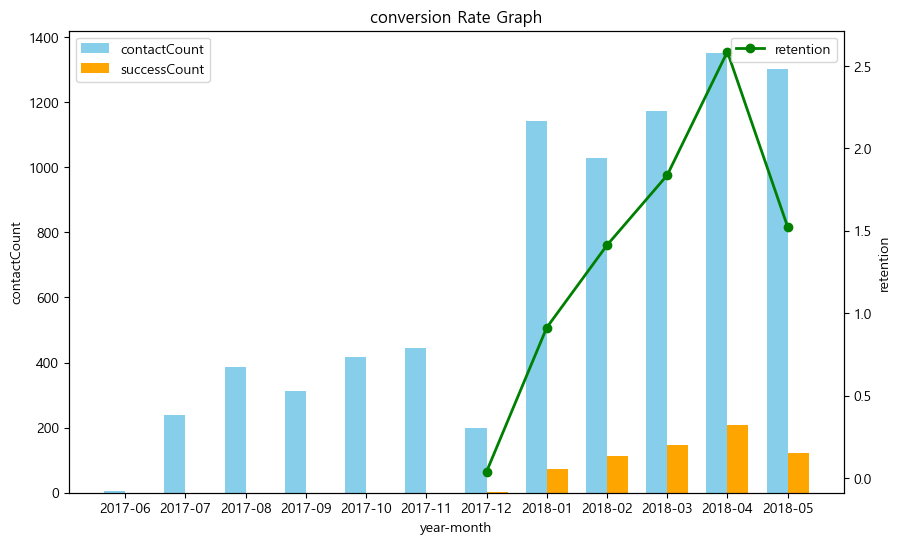

In [29]:
# 예제 데이터프레임 생성

df = finalData


# x축 위치 설정
x = np.arange(len(df))

# 막대 그래프 너비 설정
width = 0.35

# Figure와 Axes 객체 생성
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축에 대한 막대 그래프 그리기
ax1.bar(x - width/2, finalData['contactCount'], width, label='contactCount', color='skyblue')
ax1.bar(x + width/2, finalData['successCount'], width, label='successCount', color='orange')

# 첫 번째 y축 라벨 및 설정
ax1.set_xlabel('year-month')
ax1.set_ylabel('contactCount')
ax1.set_title('conversion Rate Graph')
ax1.set_xticks(x)
ax1.set_xticklabels(df['year-month'])
ax1.legend(loc='upper left')

# 두 번째 y축을 생성하여 비율 표시
ax2 = ax1.twinx()
ax2.plot(x, finalData['conversionRate'], color='green', marker='o', label='retention', linewidth=2)

# 두 번째 y축 라벨 설정
ax2.set_ylabel('retention')
ax2.legend(loc='upper right')

# 그래프 출력
plt.show()

## 분기별 전환율 그래프 생성

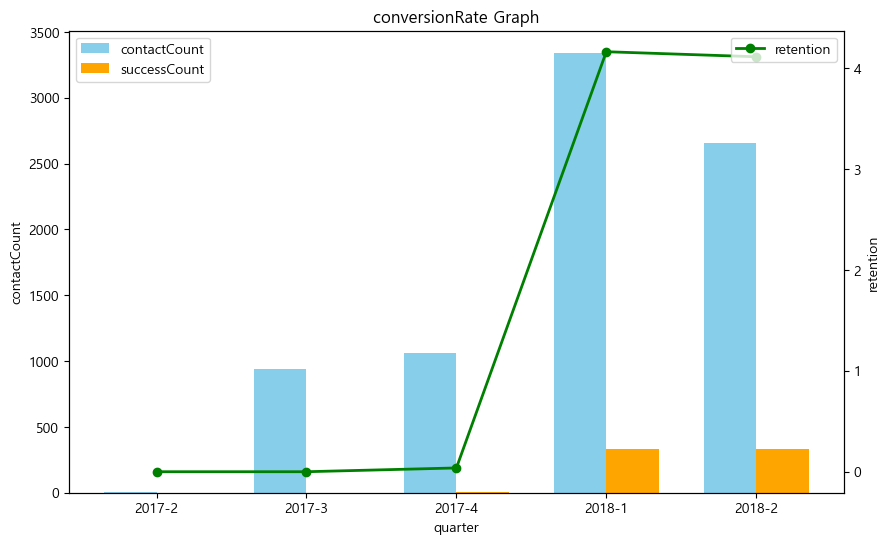

In [30]:
# 예제 데이터프레임 생성

df = quarterData

# x축 위치 설정
x = np.arange(len(df))

# 막대 그래프 너비 설정
width = 0.35

# Figure와 Axes 객체 생성
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축에 대한 막대 그래프 그리기
ax1.bar(x - width/2, df['contactCount'], width, label='contactCount', color='skyblue')
ax1.bar(x + width/2, df['successCount'], width, label='successCount', color='orange')

# 첫 번째 y축 라벨 및 설정
ax1.set_xlabel('quarter')
ax1.set_ylabel('contactCount')
ax1.set_title('conversionRate Graph')
ax1.set_xticks(x)
ax1.set_xticklabels(df['quarter'])
ax1.legend(loc='upper left')

# 두 번째 y축을 생성하여 비율 표시
ax2 = ax1.twinx()
ax2.plot(x, df['conversionRate'], color='green', marker='o', label='retention', linewidth=2)

# 두 번째 y축 라벨 설정
ax2.set_ylabel('retention')
ax2.legend(loc='upper right')

# 그래프 출력
plt.show()

## seller 특성별 분석

### 성향  데이터 EDA 및 성향별 업종 데이터 분석 

In [31]:
checkContact['first_contact_date'] = pd.to_datetime(checkContact['first_contact_date'], format = '%Y-%m-%d')

In [32]:
checkContact['won_date'] = checkContact['won_date'].fillna(pd.Timestamp('1970-01-01 01:00'))

In [33]:
checkContact['won_date'] = pd.to_datetime(checkContact['won_date'], format = '%Y-%m-%d')

In [34]:
checkContact['Period'] = checkContact['won_date'] - checkContact['first_contact_date']

In [35]:
checkContact['Period'] = checkContact['Period'].dt.days

In [36]:
periodData = checkContact[checkContact['Period']>0]

In [37]:
periodData = periodData.reset_index()

In [38]:
periodData['lead_behaviour_profile'] = periodData['lead_behaviour_profile'].squeeze()

In [39]:
periodData.groupby('lead_behaviour_profile')['Period'].mean()

lead_behaviour_profile
cat             42.914508
cat, wolf      185.750000
eagle           38.478261
eagle, cat     199.000000
eagle, wolf    149.333333
shark           78.652174
shark, cat     181.000000
shark, wolf    341.000000
wolf            84.808511
Name: Period, dtype: float64

In [40]:
periodData.groupby('lead_behaviour_profile').size()

lead_behaviour_profile
cat            386
cat, wolf        8
eagle          115
eagle, cat       3
eagle, wolf      3
shark           23
shark, cat       1
shark, wolf      1
wolf            94
dtype: int64

## 성향별 업종분포 구하기 

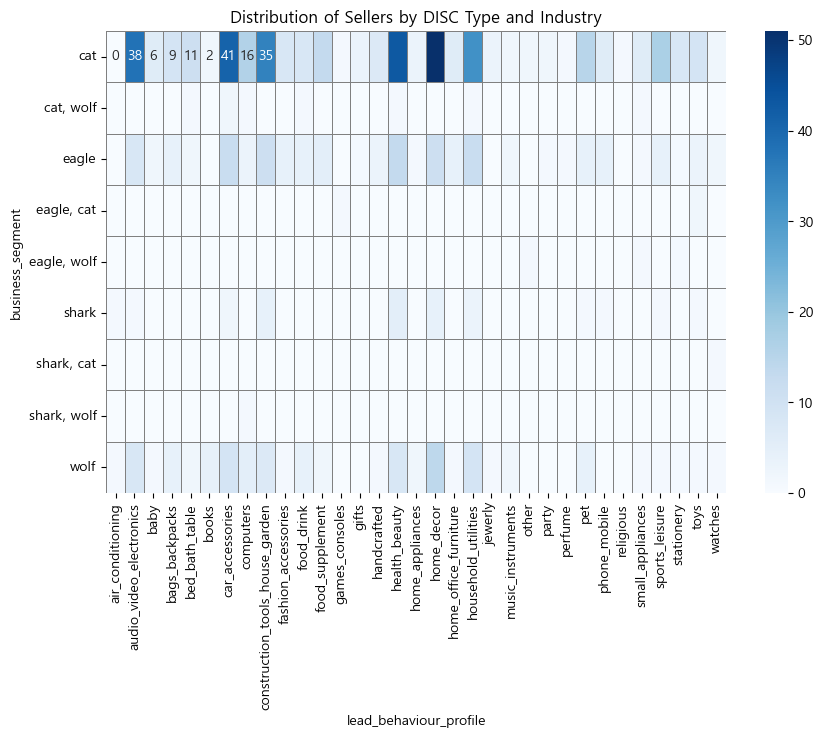

In [41]:
# 성향별 업종 분포 카운트
count_df = checkContact.groupby(['lead_behaviour_profile', 'business_segment']).size().unstack(fill_value=0)

# 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(count_df, annot=True, cmap='Blues', linewidths=0.5, linecolor='grey')
plt.title('Distribution of Sellers by DISC Type and Industry')
plt.xlabel('lead_behaviour_profile')
plt.ylabel('business_segment')
plt.show()

## 랜딩페이지 통계 
동시 노출이 맞았는지 확인 진행 : 동시 노출이 되는 랜딩 페이지는 없었고, 생각보다 랜딩페이지의 종류가 많았음 

In [42]:
landingPageResult = qualifiedLeads.groupby('landing_page_id',as_index=False).agg({'first_contact_date':['min','max']}).reset_index()
#.to_csv('landingPage_EDA.csv')

In [43]:
# 컬럼 이름을 단일 계층으로 변경
landingPageResult.columns = ['_'.join(col).strip() if col[1] else col[0] for col in landingPageResult.columns.values]

In [44]:
landingPageResult.head()

,index,landing_page_id,first_contact_date_min,first_contact_date_max
0,0,007f9098284a86ee80ddeb25d53e0af8,2017-07-05,2018-05-28
1,1,01850876d34b43494b5f9879c366877b,2018-04-02,2018-04-02
2,2,0218f6be0b76aca72ab4d00ee9e8cf10,2017-07-05,2018-05-30
3,3,03c7c0ace395d80182db07ae2c30f034,2017-11-23,2017-11-23
4,4,04a75b75d5f4f3a16b0178fbe382da00,2018-04-11,2018-04-11


### 전체 랜딩페이지 노출 기간 분포 
- 사용자가 연락처 기입한 기간 최대, 최소 날짜를 기준으로 집계 함

In [45]:
landingPageResult = qualifiedLeads.groupby('landing_page_id',as_index=False).agg({'first_contact_date':['min','max']}).reset_index()

In [46]:
# 컬럼 이름을 단일 계층으로 변경
landingPageResult.columns = ['_'.join(col).strip() if col[1] else col[0] for col in landingPageResult.columns.values]

In [47]:
landingPageResult.head()

,index,landing_page_id,first_contact_date_min,first_contact_date_max
0,0,007f9098284a86ee80ddeb25d53e0af8,2017-07-05,2018-05-28
1,1,01850876d34b43494b5f9879c366877b,2018-04-02,2018-04-02
2,2,0218f6be0b76aca72ab4d00ee9e8cf10,2017-07-05,2018-05-30
3,3,03c7c0ace395d80182db07ae2c30f034,2017-11-23,2017-11-23
4,4,04a75b75d5f4f3a16b0178fbe382da00,2018-04-11,2018-04-11


In [48]:
landingPageResult['최초연락 년-월'] = pd.to_datetime(landingPageResult['first_contact_date_min']).dt.strftime('%Y-%m') 

In [49]:
landingPageResult['period'] = pd.to_datetime(landingPageResult['first_contact_date_max']) - pd.to_datetime(landingPageResult['first_contact_date_min'])

In [50]:
landingPageResult['period'] = landingPageResult['period'].dt.days

In [51]:
sortedDataSize = landingPageResult.groupby(('최초연락 년-월')).size().reset_index(name='total_count')

In [52]:
periodDataSize = landingPageResult.groupby(('period')).size().reset_index(name='total_count')

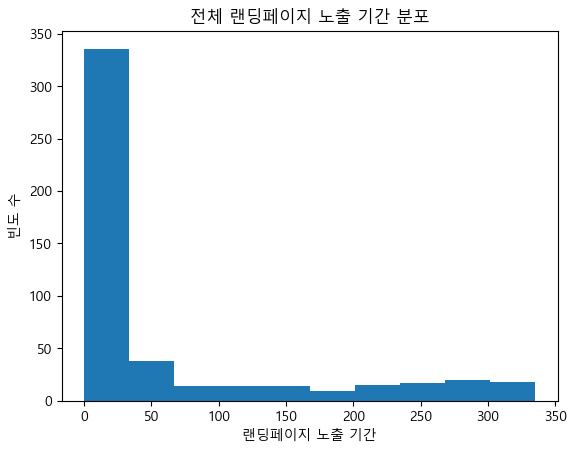

In [53]:
plt.hist(landingPageResult['period'], bins=10)  # x_data는 분포를 확인하고 싶은 데이터
plt.xlabel('랜딩페이지 노출 기간')
plt.ylabel('빈도 수')
plt.title('전체 랜딩페이지 노출 기간 분포')
plt.show()

## 랜딩페이지 노출 기간이 2018년 3월~5월 사이에 짧았는지에 대한 확인을 재진행함 
방법: 기간 범위를 줄임 

In [54]:
#first_contact_date_min	first_contact_date_max
limitedPeriod = landingPageResult.loc[(landingPageResult['first_contact_date_min'] >= '2018-03-01') & (landingPageResult['first_contact_date_min'] <'2018-05-01')]

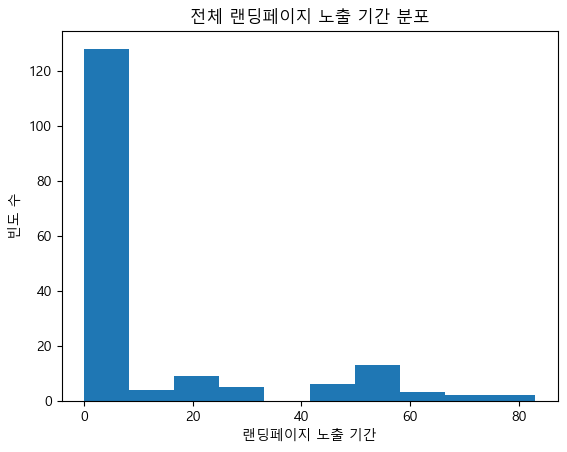

In [55]:
plt.hist(limitedPeriod['period'], bins=10)  # x_data는 분포를 확인하고 싶은 데이터
plt.xlabel('랜딩페이지 노출 기간')
plt.ylabel('빈도 수')
plt.title('전체 랜딩페이지 노출 기간 분포')
plt.show()

## 단기간 노출 랜딩페이지 분포 확인

In [56]:
zero_period = landingPageResult[landingPageResult['period']==0]

In [57]:
zero_period.head()

,index,landing_page_id,first_contact_date_min,first_contact_date_max,최초연락 년-월,period
1,1,01850876d34b43494b5f9879c366877b,2018-04-02,2018-04-02,2018-04,0
3,3,03c7c0ace395d80182db07ae2c30f034,2017-11-23,2017-11-23,2017-11,0
4,4,04a75b75d5f4f3a16b0178fbe382da00,2018-04-11,2018-04-11,2018-04,0
7,7,081b0e629b3899db213a23bc4e58a17d,2017-09-29,2017-09-29,2017-09,0
11,11,099ddda4feb08e89c402f2d38ca94b2e,2018-05-09,2018-05-09,2018-05,0


In [58]:
sortedDataSize.rename(columns={ 'total_count':'랜딩 페이지 수'},inplace=True)

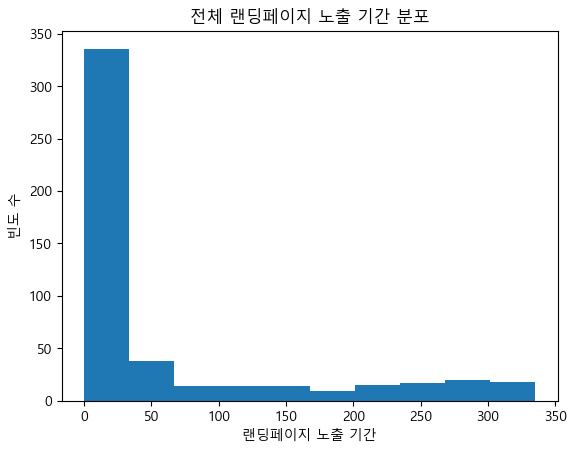

In [59]:
plt.hist(landingPageResult['period'], bins=10)  # x_data는 분포를 확인하고 싶은 데이터
plt.xlabel('랜딩페이지 노출 기간')
plt.ylabel('빈도 수')
plt.title('전체 랜딩페이지 노출 기간 분포')
plt.show()

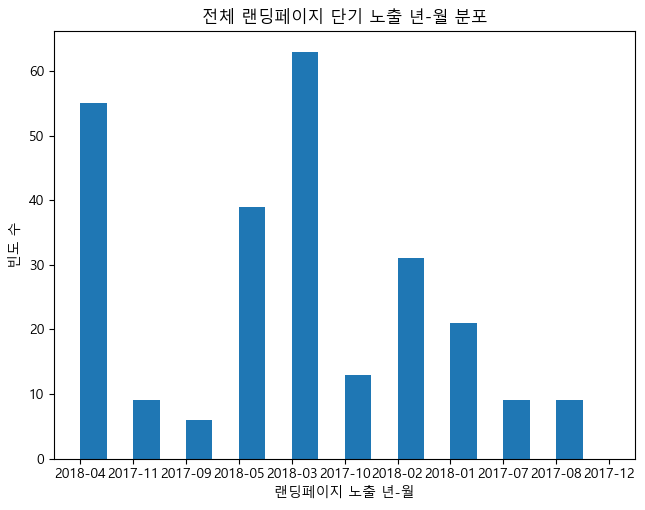

In [60]:
plt.hist(zero_period['최초연락 년-월'], bins=10, width=0.5)  # x_data는 분포를 확인하고 싶은 데이터
plt.tight_layout() 
plt.xlabel('랜딩페이지 노출 년-월')
plt.ylabel('빈도 수')
plt.title('전체 랜딩페이지 단기 노출 년-월 분포')
plt.show()

## 단기간 랜딩페이지 노출 년-월 분포 확인

In [61]:
#first_contact_date_min	first_contact_date_max
limitedPeriod = landingPageResult.loc[(landingPageResult['first_contact_date_min'] >= '2018-03-01') & (landingPageResult['first_contact_date_min'] <'2018-05-01')]

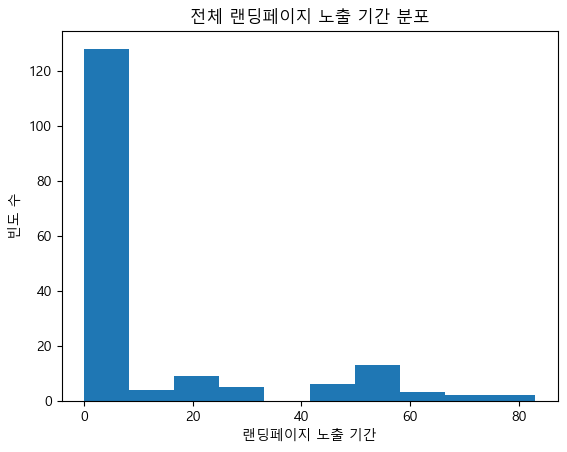

In [62]:
plt.hist(limitedPeriod['period'], bins=10)  # x_data는 분포를 확인하고 싶은 데이터
plt.xlabel('랜딩페이지 노출 기간')
plt.ylabel('빈도 수')
plt.title('전체 랜딩페이지 노출 기간 분포')
plt.show()

In [63]:
sortedDataSize.rename(columns={ 'total_count':'랜딩 페이지 수'},inplace=True)

<Axes: xlabel='최초연락 년-월'>

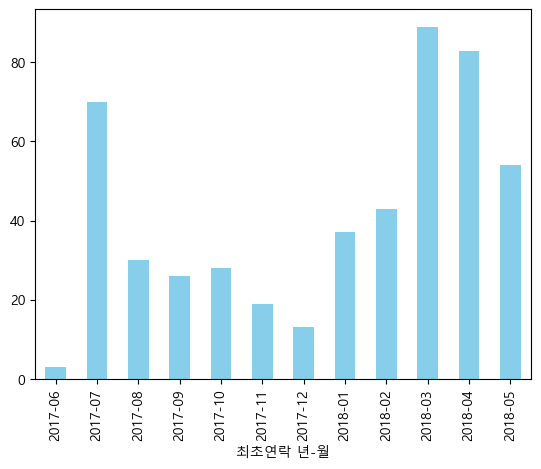

In [64]:
sortedDataSize.plot(kind='bar',x='최초연락 년-월', y='랜딩 페이지 수', color='skyblue',legend=False)

## 매출 데이터 확인

In [65]:
paymentsDataSet.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [66]:
#checkContact = pd.merge(qualifiedLeads, closedDealsWonDate, how = 'left', on ='mql_id')
paymentOrders = pd.merge(ordersDataSet, paymentsDataSet, how = 'left', on ='order_id')

In [67]:
paymentsDataSet[paymentsDataSet['order_id']=='e481f51cbdc54678b7cc49136f2d6af7']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
10770,e481f51cbdc54678b7cc49136f2d6af7,1,credit_card,1,18.12
44246,e481f51cbdc54678b7cc49136f2d6af7,3,voucher,1,2.00
91130,e481f51cbdc54678b7cc49136f2d6af7,2,voucher,1,18.59


In [68]:
ordersDataSet['order_approved_at_yearMonth'] = pd.to_datetime(ordersDataSet['order_approved_at']).dt.strftime('%Y-%m') 
#checkContact = pd.merge(qualifiedLeads, closedDealsWonDate, how = 'left', on ='mql_id')

In [69]:
#monthly_sales =
monthly_sales = paymentOrders.groupby('order_approved_at_yearMonth')['payment_value'].sum().reset_index()

In [70]:
monthly_sales.rename(columns={'order_approved_at_yearMonth':'년-월','payment_value':'매출'},inplace=True)

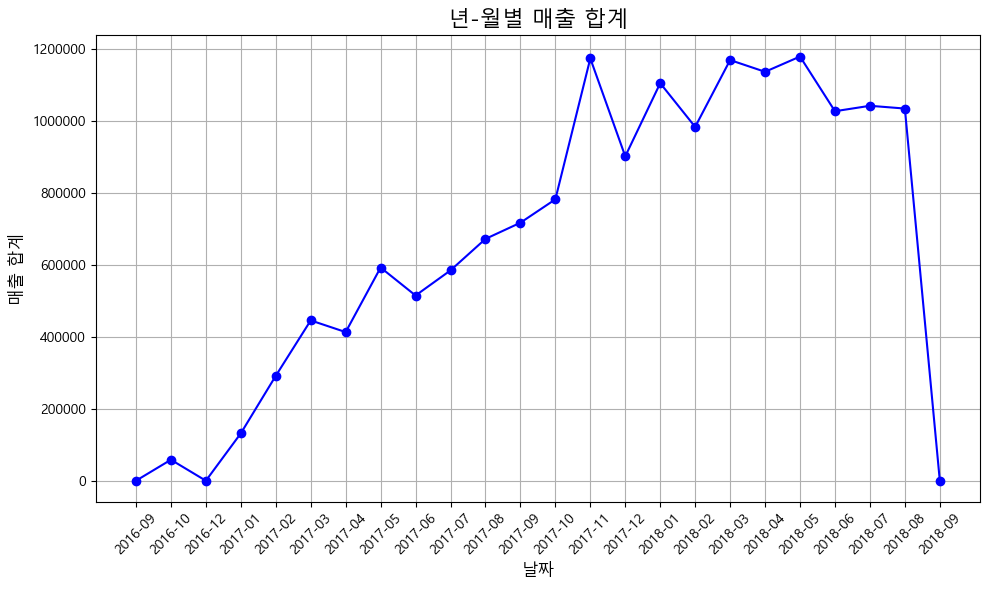

In [71]:
# 시각화 (선 그래프)
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['년-월'], monthly_sales['매출'], marker='o', linestyle='-', color='b')

# 그래프 제목 및 레이블 설정
plt.title('년-월별 매출 합계', fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('매출 합계', fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

# x축의 날짜 포맷을 조정
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
ordersItemDataSet.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [73]:
itemsDataSet = pd.merge(ordersItemDataSet, productsDataSet, how = 'left', on ='product_id')[['order_id','product_id','seller_id','product_category_name']]

In [74]:
firstPaymentDataSet = pd.merge(itemsDataSet, paymentOrders, how = 'left', on ='order_id')[['order_id','product_id','seller_id','product_category_name','payment_value','order_purchase_timestamp']]

In [75]:
cateTranslateDataSet.columns = ['product_category_name','product_category_name_english']

In [76]:
secondPaymentDataSet.head()

,order_id,product_id,seller_id,product_category_name,payment_value,order_purchase_timestamp,product_category_name_english,order_purchase_timestamp_month
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff,72.19,2017-09-13 08:59:02,cool_stuff,2017-10
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,259.83,2017-04-26 10:53:06,pet_shop,2018-07
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao,216.87,2018-01-14 14:33:31,furniture_decor,2018-08
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria,25.78,2018-08-08 10:00:35,perfumery,2017-11
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim,218.04,2017-02-04 13:57:51,garden_tools,2018-02


## 전기간 카테고리별 매출 확인

In [111]:

secondPaymentDataSet['order_purchase_timestamp_month'] = pd.to_datetime(ordersDataSet['order_approved_at']).dt.strftime('%Y-%m') 
#minmax 걸고, 그 다음에 sellerid 테이블을 기준으로 걸면 될듯 
secondPaymentDataSet.head()
productCategoryTable = secondPaymentDataSet.groupby(['seller_id','product_category_name']).agg({'order_purchase_timestamp':['min','max']}).reset_index()

In [112]:
secondPaymentDataSet

,order_id,product_id,seller_id,product_category_name,payment_value,order_purchase_timestamp,product_category_name_english,order_purchase_timestamp_month
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff,72.19,2017-09-13 08:59:02,cool_stuff,2017-10
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,259.83,2017-04-26 10:53:06,pet_shop,2018-07
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao,216.87,2018-01-14 14:33:31,furniture_decor,2018-08
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria,25.78,2018-08-08 10:00:35,perfumery,2017-11
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim,218.04,2017-02-04 13:57:51,garden_tools,2018-02
...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,utilidades_domesticas,343.40,2018-04-23 13:57:06,housewares,NaN
117600,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,informatica_acessorios,386.53,2018-07-14 10:26:46,computers_accessories,NaN
117601,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,esporte_lazer,116.85,2017-10-23 17:07:56,sports_leisure,NaN
117602,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,informatica_acessorios,64.71,2017-08-14 23:02:59,computers_accessories,NaN


In [113]:
categorySales = secondPaymentDataSet.groupby(['product_category_name_english','order_purchase_timestamp_month']).sum('payment_value').reset_index()

In [114]:
categorySales.columns = ['카테고리명','년-월', '총구매금액']

In [115]:
categorySales['카테고리명'].nunique()

71

In [116]:
# 천 단위 포맷 설정 함수
def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x)

In [117]:
categorySales_sum = categorySales.groupby('카테고리명').sum('총구매금액').reset_index()

In [118]:
categorySales_pivot = categorySales.pivot_table(index='년-월', columns = '카테고리명', values='총구매금액')

In [119]:
categorySales_sum.head()

,카테고리명,총구매금액
0,agro_industry_and_commerce,101899.13
1,air_conditioning,70674.98
2,art,20444.53
3,arts_and_craftmanship,2011.85
4,audio,50463.60


In [134]:
# 매출 상위 10개 카테고리 추출
top_10_categories = categorySales_sum.nlargest(10, '총구매금액')['카테고리명']

In [121]:
# 원본 데이터에서 상위 10개 카테고리만 필터링
filtered_df = categorySales[categorySales['카테고리명'].isin(top_10_categories)]

In [122]:
filtered_df['카테고리명'].unique()

array(['auto', 'bed_bath_table', 'computers_accessories', 'cool_stuff',
       'furniture_decor', 'garden_tools', 'health_beauty', 'housewares',
       'sports_leisure', 'watches_gifts'], dtype=object)

In [123]:
filtered_df.head()

,카테고리명,년-월,총구매금액
96,auto,2016-09,31.79
97,auto,2016-10,1736.98
98,auto,2017-01,4326.98
99,auto,2017-02,9928.97
100,auto,2017-03,15112.69


In [124]:
categorySales_pivot = filtered_df.pivot_table(index='년-월', columns = '카테고리명', values='총구매금액')


In [125]:
categorySales_pivot.head()

카테고리명,auto,bed_bath_table,computers_accessories,cool_stuff,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,watches_gifts
년-월,,,,,,,,,,
2016-09,31.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1736.98,3652.38,3588.43,3152.08,3353.33,898.21,7842.25,6640.62,3995.27,4259.50
2016-12,NaN,NaN,NaN,NaN,55.10,NaN,NaN,NaN,NaN,NaN
2017-01,4326.98,9091.14,11517.35,4678.52,8594.73,6677.33,10587.20,6261.70,11309.13,11454.00
2017-02,9928.97,29807.02,32349.83,12782.79,19954.43,13044.15,30504.62,15831.53,19308.34,17534.42


In [126]:
categorySales_pivot.head()

카테고리명,auto,bed_bath_table,computers_accessories,cool_stuff,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,watches_gifts
년-월,,,,,,,,,,
2016-09,31.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1736.98,3652.38,3588.43,3152.08,3353.33,898.21,7842.25,6640.62,3995.27,4259.50
2016-12,NaN,NaN,NaN,NaN,55.10,NaN,NaN,NaN,NaN,NaN
2017-01,4326.98,9091.14,11517.35,4678.52,8594.73,6677.33,10587.20,6261.70,11309.13,11454.00
2017-02,9928.97,29807.02,32349.83,12782.79,19954.43,13044.15,30504.62,15831.53,19308.34,17534.42


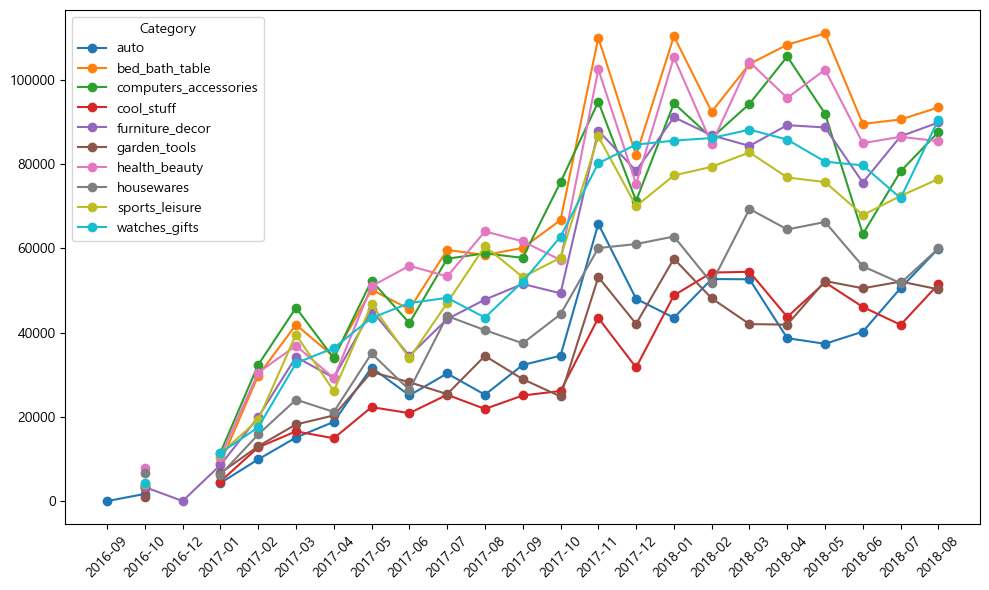

In [127]:
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))


# 각 카테고리별로 꺾은선 추가
for category in categorySales_pivot.columns:
    plt.plot(categorySales_pivot.index, categorySales_pivot[category], marker='o', label= category)

        
# 범례 추가
plt.legend(title='Category')
    
    
# x축의 날짜 포맷을 조정
plt.xticks(rotation=45)

plt.tight_layout()

### 카테고리별 입점자 추이 

In [128]:
contactedSellers = closedDeals[closedDeals['won_date'].notna()]
cateMerge = pd.merge(contactedSellers,secondPaymentDataSet, how = 'left', on ='seller_id')
cateMerge.head()
productCategoryTable = secondPaymentDataSet.groupby(['seller_id', 'product_category_name_english'],as_index=False).agg({'order_purchase_timestamp' : ['min', 'max']}).reset_index(drop=True)


In [129]:

# 컬럼 이름을 단일 계층으로 변경
productCategoryTable.columns = ['_'.join(col).strip() if col[1] else col[0] for col in productCategoryTable.columns.values]

mergedResult = pd.merge(contactedSellers, productCategoryTable, how='left', on='seller_id')[['mql_id','seller_id', 'won_date', 'product_category_name_english', 'order_purchase_timestamp_min', 'order_purchase_timestamp_max']]

In [154]:

yesResult['won_date'] = pd.to_datetime(yesResult['won_date']).dt.strftime('%Y-%m') 
yesCount = yesResult.groupby(['product_category_name_english','won_date']).size().reset_index(name='Count') 

C:\Users\mandy\AppData\Local\Temp\ipykernel_23600\631003134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yesResult['won_date'] = pd.to_datetime(yesResult['won_date']).dt.strftime('%Y-%m')


In [169]:
countResult = yesResult.groupby(['product_category_name_english']).size().reset_index(name='Count')

In [170]:
countResult.head()

,product_category_name_english,Count
0,agro_industry_and_commerce,4
1,air_conditioning,4
2,art,6
3,arts_and_craftmanship,3
4,audio,1


In [171]:
# 매출 상위 10개 카테고리 추출
top_10_categories = countResult.nlargest(10, 'Count')['product_category_name_english']

In [172]:
top_10_categories 

33            health_beauty
37               housewares
51           sports_leisure
5                      auto
6                      baby
54                     toys
30          furniture_decor
14    computers_accessories
52               stationery
32             garden_tools
Name: product_category_name_english, dtype: object

<Axes: ylabel='product_category_name_english'>

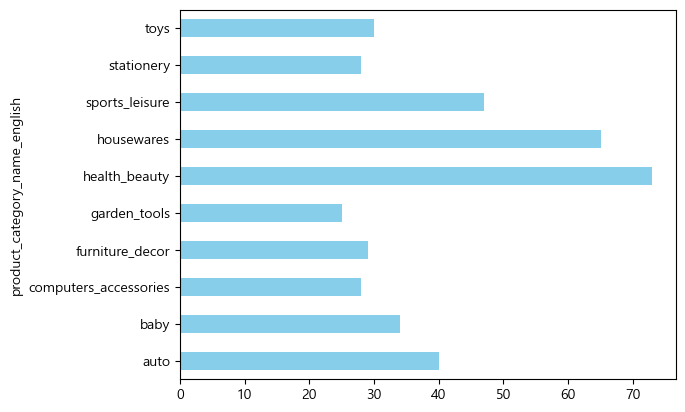

In [173]:
countResult[countResult['product_category_name_english'].isin(top_10_categories)].plot(kind='barh',x='product_category_name_english', y='Count', color='skyblue',legend=False)

In [175]:
countResult = yesResult.groupby(['product_category_name_english','won_date']).size().reset_index(name='Count')

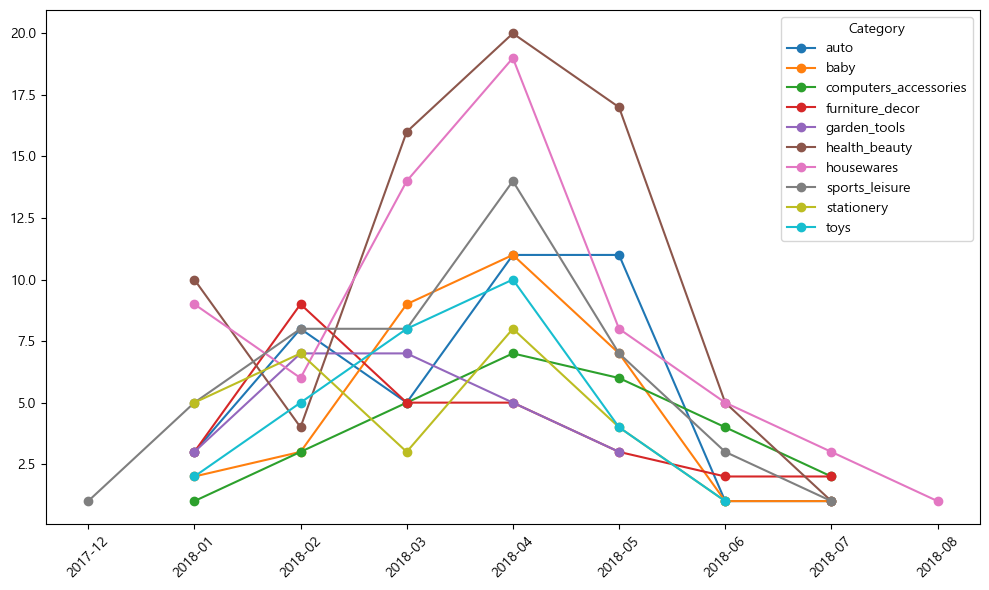

In [177]:
categorySales_pivot = countResult[countResult['product_category_name_english'].isin(top_10_categories)].pivot_table(index='won_date', columns = 'product_category_name_english', values='Count')

# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))



# 각 카테고리별로 꺾은선 추가
for category in categorySales_pivot.columns:
    plt.plot(categorySales_pivot.index, categorySales_pivot[category], marker='o', label= category)

        
# 범례 추가
plt.legend(title='Category')
    
    
# x축의 날짜 포맷을 조정
plt.xticks(rotation=45)

plt.tight_layout()

## 입점기간 확인

In [131]:
mergedResult['Period'] = pd.to_datetime(mergedResult['order_purchase_timestamp_min']) - pd.to_datetime(mergedResult['won_date']) 
mergedResult.head()
mergedResult['Period'] = mergedResult['Period'].dt.days
yesResult = mergedResult[mergedResult['Period'].notna()]


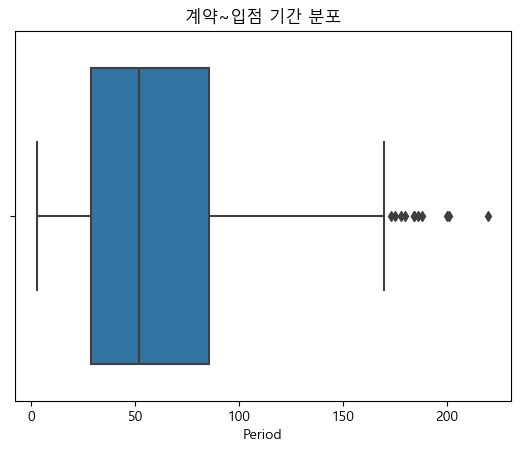

,mql_id,seller_id,won_date,product_category_name_english,order_purchase_timestamp_min,order_purchase_timestamp_max,Period
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,2018-02-26 19:58,garden_tools,2018-07-23 20:50:50,2018-07-23 20:50:50,147.0
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,2018-02-26 19:58,pet_shop,2018-06-20 21:40:18,2018-06-21 15:42:55,114.0
3,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,2018-06-05 17:27,baby,2018-06-29 07:51:49,2018-07-24 21:46:29,23.0
4,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,2018-06-05 17:27,computers_accessories,2018-06-21 20:37:12,2018-08-10 19:49:38,16.0
5,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,2018-06-05 17:27,consoles_games,2018-06-11 14:32:25,2018-08-15 17:35:07,5.0


In [132]:
import seaborn as sns

# 박스플롯 그리기
sns.boxplot(x=mergedResult['Period'])
plt.title('계약~입점 기간 분포')
plt.show()

countResult = yesResult.groupby('product_category_name_english').size().reset_index(name='Count')

countResult = countResult[countResult['product_category_name_english'].isin(top_10_categories)]

yesResult.head()